# Florida: ARIMA Time-Series Modeling Notebook 

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from collections import Counter

from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# Read in data

In [2]:
# df = pd.read_csv('../../COVID-19_Nursing_Home_Dataset.csv')

## Split data

Due to size of data file, split data by week submitted to get smaller files that are available to upload. 
> This is commented out so that it only runs when needed.

In [3]:
# def split_data(df,dates):
#     for date in dates:    
#         frame = df[df['Week Ending'] == date]
#         reformatted_date = date.replace('/', '-')
#         frame.to_csv(f'../data/{reformatted_date}-data.csv', index = False)

# dates = df['Week Ending'].unique()

# split_data(df, dates)

## Concatenating files

Create a function that can concatenate the each of the csv files into a single data frame.

In [4]:
df_lst = []
for f in os.listdir('../data'):
    temp = pd.read_csv('../data/' + f)
    df_lst.append(temp)
df = pd.concat(df_lst, ignore_index=True)

In [5]:
# determining the number of weeks for which data is available
week_num = len(df['Week Ending'].unique())
print('num weeks:',week_num)

# Dropping rows where no submitted data
df = df[df['Submitted Data'] == 'Y']

# dropping rows that didn't pass quality assurance check
df = df[df['Passed Quality Assurance Check'] == 'Y']


num weeks: 38


In [6]:
# removing nursing homes who have submissions for each week

submission_counts = Counter(df['Federal Provider Number'])
keys = submission_counts.keys()
to_drop = []
for key in keys:
    if submission_counts[key] < week_num:
        to_drop.append(key)
to_keep = keys-to_drop
print('original:',len(keys))
print('to be dropped:',len(to_drop))
print('to keep:',len(to_keep))

original: 16896
to be dropped: 5914
to keep: 10982


In [7]:
# drop rows for nursing homes that don't meet the criteria fewer entries
df = df[df['Federal Provider Number'].isin(to_keep)]

In [8]:
# change the week column to datetime format
df['Week Ending'] = pd.to_datetime(df['Week Ending'])

# Modeling

In [9]:
# function to get the p-values for adfuller test for each of the columns in the dataframe 

def interpret_dftest(df):
    '''
    Returns p-value for the Dickey-Fuller test for each feature in DataFrame.
    ----
    Parameters
        Type: DataFrame
        Description: Time series features
    ----
    Output
        Type: DataFrame
        Description: DataFrame of p-values for time-series data
    '''
    results = []
    best_col = None
    best_p = 2
    
    for col in df.columns:
        result = {}
        result['column'] = col
        dftest = adfuller(df[col])
        result['Test Statistic'] = dftest[0]
        result['p-value'] = dftest[1]
        result['1 - p-value'] = 1-dftest[1]
        results.append(result)
        if dftest[1] < .9:
            if dftest[1] < best_p:
                best_p = dftest[1]
                best_col = col
        elif dftest[1] >= .9:
            if (1-dftest[1]) < best_p:
                best_p = (1-dftest[1])
                best_col = col
    
    print('best_col:', best_col)
    print('best_p:', best_p)
    return pd.DataFrame(results)

## FL

In [10]:
fl = df[df['Provider State']=='FL']

fl = fl[[
    'Week Ending', 'Total Number of Occupied Beds',
    'Residents Weekly COVID-19 Deaths',
    'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents',
    'Weekly Resident COVID-19 Deaths Per 1,000 Residents'
]]
fl_avgs = fl.groupby(by='Week Ending').mean()

### 'Total Number of Occupied Beds'

In [11]:
fl_occupied = fl_avgs[['Total Number of Occupied Beds']].copy()
fl_occupied['diff1'] = fl_occupied['Total Number of Occupied Beds'].diff()
fl_occupied['diff2'] = fl_occupied['Total Number of Occupied Beds'].diff().diff()
fl_occupied.dropna(inplace = True)


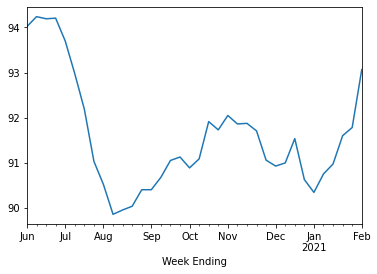

In [12]:
fl_occupied['Total Number of Occupied Beds'].plot(label = 'orig');


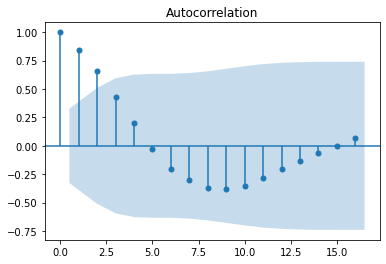

In [13]:
plot_acf(fl_occupied['Total Number of Occupied Beds']);


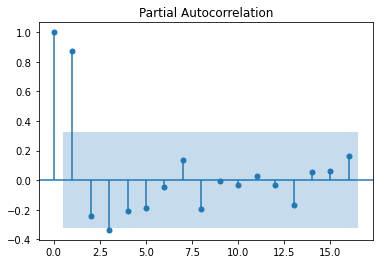

In [14]:
plot_pacf(fl_occupied['Total Number of Occupied Beds']);


In [15]:
interpret_dftest(fl_occupied)


best_col: diff1
best_p: 0.02411258127393451


,column,Test Statistic,p-value,1 - p-value
0,Total Number of Occupied Beds,-1.756312,0.402357,0.597643
1,diff1,-3.134362,0.024113,0.975887
2,diff2,-2.987137,0.036113,0.963887


In [16]:
y_train, y_test = train_test_split(fl_occupied['Total Number of Occupied Beds'],shuffle=False, test_size = .1)


*Note: The code in the two cells directly below, as well as all other iterations of it in this notebook, were adapted from the [7.07-lesson-arima-modeling repo](https://git.generalassemb.ly/DSIR-20201214-E/lesson-ARIMA), originally written by Matt Brems, Joseph Nelson and Justin Pounders.*

In [17]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0

# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    
            except:
                pass
            
print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)

best aic: 39.33899200487457
best p: 1
best d: 1
best q: 0


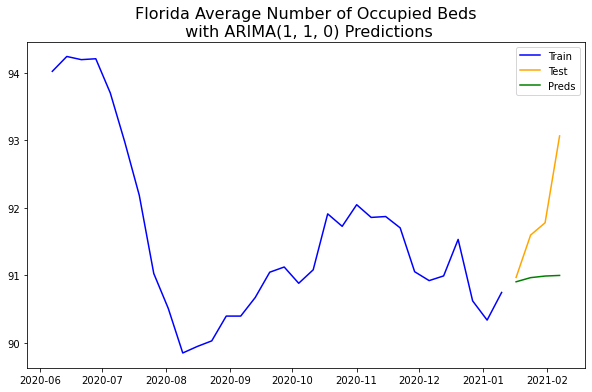

In [18]:
# Instantiate best model.
fl_occ_model = ARIMA(endog=y_train, order=(best_p, best_d, best_q))

# Fit ARIMA model.
arima = fl_occ_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start=y_test.index[0], end=y_test.index[-1])

# Plot data.
plt.figure(figsize=(10, 6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color='blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color='orange', label='Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color='green', label='Preds')

plt.title(
    label=f'Florida Average Number of Occupied Beds\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions',
    fontsize=16)
plt.legend()

plt.savefig('../assets/fl_avg_num_occupied_beds.png');

### 'Residents Weekly COVID-19 Deaths'

In [19]:
fl_weekly_deaths = fl_avgs[['Residents Weekly COVID-19 Deaths']].copy()

fl_weekly_deaths['diff1'] = fl_weekly_deaths['Residents Weekly COVID-19 Deaths'].diff()
fl_weekly_deaths['diff2'] = fl_weekly_deaths['Residents Weekly COVID-19 Deaths'].diff().diff()
fl_weekly_deaths.dropna(inplace = True)

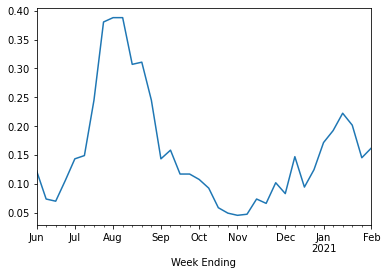

In [20]:
fl_weekly_deaths['Residents Weekly COVID-19 Deaths'].plot(label = 'orig');


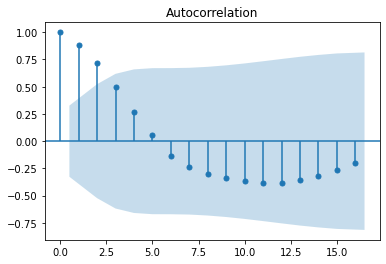

In [21]:
plot_acf(fl_weekly_deaths['Residents Weekly COVID-19 Deaths']);


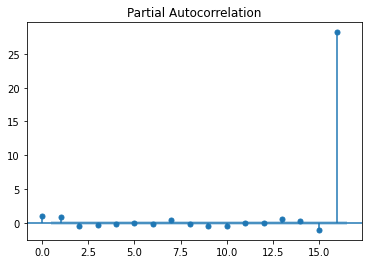

In [22]:
plot_pacf(fl_weekly_deaths['Residents Weekly COVID-19 Deaths']);


In [23]:
interpret_dftest(fl_weekly_deaths)


best_col: diff2
best_p: 6.208311486902389e-10


,column,Test Statistic,p-value,1 - p-value
0,Residents Weekly COVID-19 Deaths,-2.446687,1.289904e-01,0.871010
1,diff1,-3.049468,3.052592e-02,0.969474
2,diff2,-7.030356,6.208311e-10,1.000000


In [24]:
y_train, y_test = train_test_split(fl_weekly_deaths['Residents Weekly COVID-19 Deaths'],shuffle=False, test_size = .1)


In [25]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0 <= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d

            except:
                pass
            
print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)


best aic: 90000000000000000
best p: 0
best d: 0
best q: 0


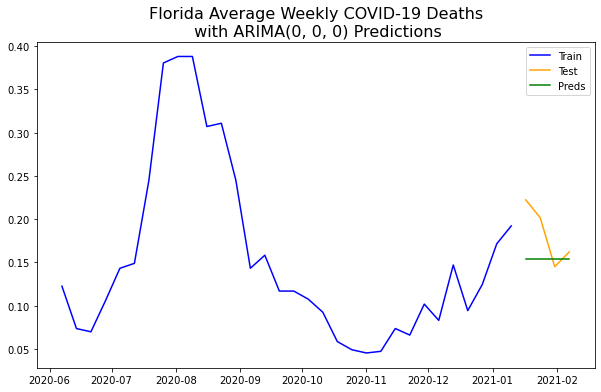

In [26]:
# Instantiate best model.
fl_week_deaths_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = fl_week_deaths_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'Florida Average Weekly COVID-19 Deaths\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/fl_weekly_avg_num_covid_deaths.png');

### 'Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'

In [27]:
fl_weekly_confirmed_cases = fl_avgs[['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']].copy()

fl_weekly_confirmed_cases['diff1'] = fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].diff()
fl_weekly_confirmed_cases['diff2'] = fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].diff().diff()
fl_weekly_confirmed_cases.dropna(inplace = True)


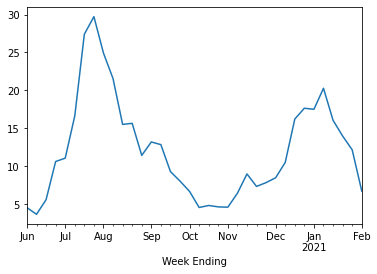

In [28]:
fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'].plot(label = 'orig');


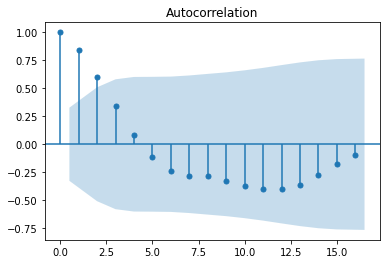

In [29]:
plot_acf(fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']);


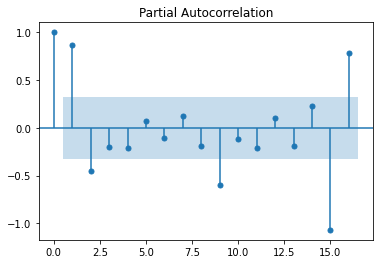

In [30]:
plot_pacf(fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents']);


In [31]:
interpret_dftest(fl_weekly_confirmed_cases)


best_col: diff2
best_p: 3.250655214892537e-07


,column,Test Statistic,p-value,1 - p-value
0,Weekly Resident Confirmed COVID-19 Cases Per 1...,-1.643187,4.605962e-01,0.539404
1,diff1,-3.563669,6.494822e-03,0.993505
2,diff2,-5.870388,3.250655e-07,1.000000


In [32]:
y_train, y_test = train_test_split(fl_weekly_confirmed_cases['Weekly Resident Confirmed COVID-19 Cases Per 1,000 Residents'],shuffle=False, test_size = .1)


In [33]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    

            except:
                pass

print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)


best aic: 161.96295183365766
best p: 1
best d: 2
best q: 1


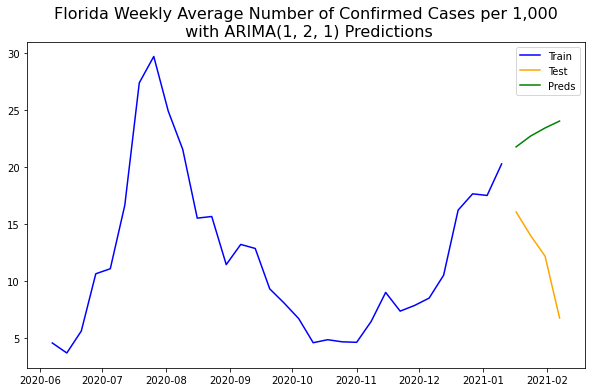

In [34]:
# Instantiate best model.
fl_week_conf_cases_per_thous_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = fl_week_conf_cases_per_thous_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'Florida Weekly Average Number of Confirmed Cases per 1,000\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/fl_avg_num_confirmed_cases_per_thous.png');


### 'Weekly Resident COVID-19 Deaths Per 1,000 Residents'

In [35]:
fl_weekly_covid_deaths_per_thous = fl_avgs[['Weekly Resident COVID-19 Deaths Per 1,000 Residents']].copy()

fl_weekly_covid_deaths_per_thous['diff1'] = fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].diff()
fl_weekly_covid_deaths_per_thous['diff2'] = fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].diff().diff()
fl_weekly_covid_deaths_per_thous.dropna(inplace = True)


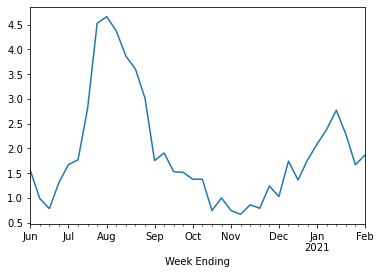

In [36]:
fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'].plot(label = 'orig');


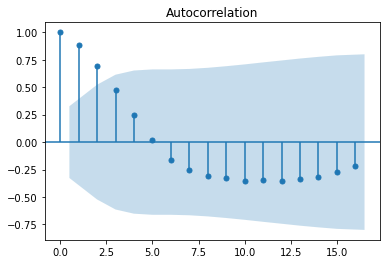

In [37]:
plot_acf(fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents']);


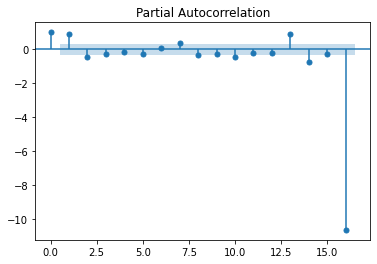

In [38]:
plot_pacf(fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents']);


In [39]:
interpret_dftest(fl_weekly_covid_deaths_per_thous)


best_col: diff2
best_p: 1.231250656110204e-09


,column,Test Statistic,p-value,1 - p-value
0,"Weekly Resident COVID-19 Deaths Per 1,000 Resi...",-1.449713,5.582248e-01,0.441775
1,diff1,-3.180418,2.114653e-02,0.978853
2,diff2,-6.908252,1.231251e-09,1.000000


In [40]:
y_train, y_test = train_test_split(fl_weekly_covid_deaths_per_thous['Weekly Resident COVID-19 Deaths Per 1,000 Residents'],shuffle=False, test_size = .1)


In [41]:
# Starting AIC, p, and q.
best_aic = 9 * (10**16)
best_p = 0
best_q = 0 
best_d = 0
# Use nested for loop to iterate over values of p and q.

for p in range(5):
    for q in range(5):
        for d in range(3):
        
        # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order = (p, d, q))

                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if 0<= model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_q = q
                    best_d = d
                    

            except:
                pass
            
print('best aic:',best_aic)
print('best p:', best_p)
print('best d:', best_d)
print('best q:', best_q)

best aic: 51.405962206087764
best p: 0
best d: 1
best q: 4


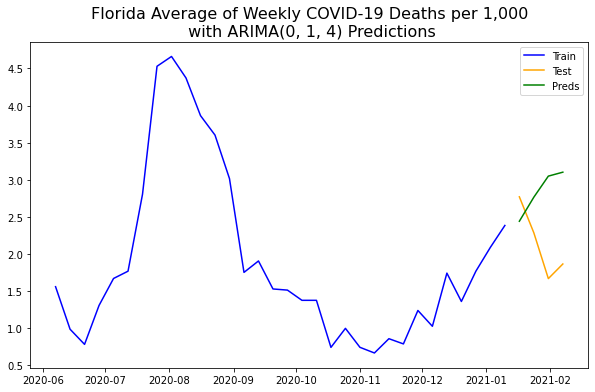

In [42]:
# Instantiate best model.
fl_weekly_deaths_per_thous_model = ARIMA(endog = y_train, order = (best_p,best_d,best_q))

# Fit ARIMA model.
arima = fl_weekly_deaths_per_thous_model.fit()

# Generate predictions based on test set.
preds = arima.predict(start = y_test.index[0], end= y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label='Train')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'Test')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'Preds')

plt.title(label = f'Florida Average of Weekly COVID-19 Deaths per 1,000\n with ARIMA({best_p}, {best_d}, {best_q}) Predictions', fontsize=16)
plt.legend()

plt.savefig('../assets/fl_weekly_avg_covid_deaths_per_1000.png');